### Import model and data

In [1]:
from tensorflow.keras.models import load_model
import numpy as np

model_path = "../models/model_2.h5"
model = load_model(model_path)

2023-03-07 20:08:41.296406: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 20:08:46.679332: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.vgg16 import VGG16

In [3]:
train_data_dir = '../raw_data/Training/'
test_data_dir = '../raw_data/Testing/'


train_ds, val_ds = image_dataset_from_directory(
  train_data_dir,
  labels = "inferred",
  label_mode = "categorical",
  seed=123,
  image_size=(255, 255),
  validation_split = 0.2,
  subset="both",
  color_mode = 'rgb',
  batch_size= 40)

# We define a second one for the test data

test_ds = image_dataset_from_directory(
  test_data_dir,
  labels = "inferred",
  label_mode = "categorical",
  seed=123,
  image_size=(255, 255),
  color_mode = 'rgb',
  batch_size= 40)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


In [4]:
base_model = VGG16(weights = "imagenet", include_top = False, input_shape = (255, 255, 3))
model = Sequential()
model.add(layers.Input(shape = (255, 255, 3)))
model.add(base_model)
model.add(layers.Conv2D(16, (3, 3), activation = 'relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(4, activation='softmax'))
base_model.trainable = False

adam = optimizers.Adam(learning_rate = 0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 16)          73744     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 16)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 144)               0         
                                                                 
 dense (Dense)               (None, 16)                2320      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                        

In [6]:
history = model.fit(
        train_ds,
        batch_size=64,
        epochs=1)

 28/115 [======>.......................] - ETA: 8:08 - loss: 2.4105 - accuracy: 0.3696

In [ ]:
def get_image_from_dataset (dataset, batch_num, image_num):
    for images, labels in dataset.take(batch_num):
        numpy_image = images.numpy()[image_num]/255
        numpy_label = labels.numpy()[image_num]
    
    return (numpy_image, numpy_label)

In [ ]:
def get_images_from_dataset (dataset, batch_num):
    for images, labels in dataset.take(batch_num):
        numpy_images = images.numpy()/255
        numpy_labels = labels.numpy()
    
    return (numpy_images, numpy_labels)

In [ ]:
datapoint = get_image_from_dataset(train_ds, 1, 1)
data = get_images_from_dataset(train_ds, 1)

### Activation visualization

In [ ]:
from tf_explain.core.activations import ExtractActivations

ActViz = ExtractActivations()
grid = ActViz.explain(data, model, layers_name='conv2d_7')
ActViz.save(grid, ".", "ActViz.png")

ValueError: in user code:

    File "/Users/victorvoneisenhart-rothe/.pyenv/versions/3.10.6/envs/braintumorclassification/lib/python3.10/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Users/victorvoneisenhart-rothe/.pyenv/versions/3.10.6/envs/braintumorclassification/lib/python3.10/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/victorvoneisenhart-rothe/.pyenv/versions/3.10.6/envs/braintumorclassification/lib/python3.10/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/victorvoneisenhart-rothe/.pyenv/versions/3.10.6/envs/braintumorclassification/lib/python3.10/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Users/victorvoneisenhart-rothe/.pyenv/versions/3.10.6/envs/braintumorclassification/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/victorvoneisenhart-rothe/.pyenv/versions/3.10.6/envs/braintumorclassification/lib/python3.10/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_56" is incompatible with the layer: expected shape=(None, 255, 255, 3), found shape=(None, 255, 3)


### GradCam

In [281]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 16)          73744     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 3, 3, 16)         0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 144)               0         
                                                                 
 dense_12 (Dense)            (None, 16)                2320      
                                                                 
 dropout_6 (Dropout)         (None, 16)                0         
                                                     

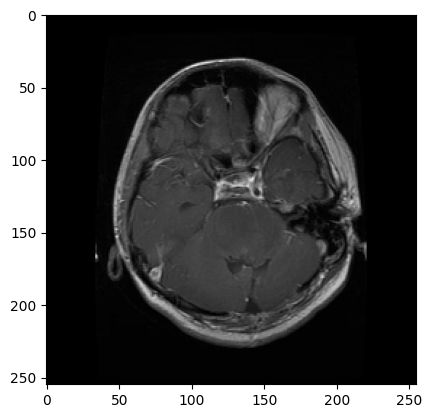

In [256]:
# Load a sample image (or multiple ones)
IMAGE_PATH = '/Users/victorvoneisenhart-rothe/code/Victorvone/braintumorclassification/braintumorclassification/raw_data/Testing/glioma/Te-gl_0010.jpg'\
    
img = load_img(IMAGE_PATH, target_size=(255, 255))
img = img_to_array(img)/255
data = ([img], None)
plt.imshow(img)

In [282]:
from tf_explain.core.grad_cam import GradCAM

#Start explainer
gradcam = GradCAM()
grid = gradcam.explain(data, model, class_index=0, layer_name='conv2d_7') 

gradcam.save(grid, "../Visualizations/", "grad_cam.png")

### Occlusion sensitivity map

In [261]:
from tf_explain.core.occlusion_sensitivity import OcclusionSensitivity

#Start explainer
occsens = OcclusionSensitivity()
grid = occsens.explain(data, model, class_index=0, patch_size=4) 

occsens.save(grid, "../Visualizations/", "OcclusionSensitivity.png")

128/128 [==============================] - 557s 4s/step


### VanillaGradients

In [260]:
from tf_explain.core.vanilla_gradients import VanillaGradients

Vanillagrad = VanillaGradients()
grid = Vanillagrad.explain(data, model, class_index=0) 

Vanillagrad.save(grid, "../Visualizations/", "VanillaGradient.png")

/var/folders/yg/kt4pdk955453dzxyb3ppm5200000gn/T/ipykernel_3962/1085510129.py:4: UserWarning: Unsupported model architecture for VanillaGradients. The last two layers of the model should be: a layer which computes class scores with no activation, followed by an activation layer.
  grid = explainer.explain(data, model, class_index=0)
